# 1. Exploring the data

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# print(os.listdir('../input/'))
# print(os.listdir('./'))

training_data_set = pd.read_csv('../input/train.csv')
testing_data_set = pd.read_csv('../input/test.csv')

print("Training data set size is {} samples.".format(len(training_data_set)))
print("Test data set size is {} samples.".format(len(testing_data_set)))

Training data set size is 3000 samples.
Test data set size is 4398 samples.


## 1.1 Checking out the columns and types of data

In [3]:
training_data_set.head()

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
0,1,"[{'id': 313576, 'name': 'Hot Tub Time Machine ...",14000000,"[{'id': 35, 'name': 'Comedy'}]",NaN,tt2637294,en,Hot Tub Time Machine 2,"When Lou, who has become the ""father of the In...",6.575393,/tQtWuwvMf0hCc2QR2tkolwl7c3c.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",2/20/15,93.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The Laws of Space and Time are About to be Vio...,Hot Tub Time Machine 2,"[{'id': 4379, 'name': 'time travel'}, {'id': 9...","[{'cast_id': 4, 'character': 'Lou', 'credit_id...","[{'credit_id': '59ac067c92514107af02c8c8', 'de...",12314651
1,2,"[{'id': 107674, 'name': 'The Princess Diaries ...",40000000,"[{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...",NaN,tt0368933,en,The Princess Diaries 2: Royal Engagement,Mia Thermopolis is now a college graduate and ...,8.248895,/w9Z7A0GHEhIp7etpj0vyKOeU1Wx.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}]","[{'iso_3166_1': 'US', 'name': 'United States o...",8/6/04,113.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,It can take a lifetime to find true love; she'...,The Princess Diaries 2: Royal Engagement,"[{'id': 2505, 'name': 'coronation'}, {'id': 42...","[{'cast_id': 1, 'character': 'Mia Thermopolis'...","[{'credit_id': '52fe43fe9251416c7502563d', 'de...",95149435
2,3,NaN,3300000,"[{'id': 18, 'name': 'Drama'}]",http://sonyclassics.com/whiplash/,tt2582802,en,Whiplash,"Under the direction of a ruthless instructor, ...",64.299990,/lIv1QinFqz4dlp5U4lQ6HaiskOZ.jpg,"[{'name': 'Bold Films', 'id': 2266}, {'name': ...","[{'iso_3166_1': 'US', 'name': 'United States o...",10/10/14,105.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,The road to greatness can take you to the edge.,Whiplash,"[{'id': 1416, 'name': 'jazz'}, {'id': 1523, 'n...","[{'cast_id': 5, 'character': 'Andrew Neimann',...","[{'credit_id': '54d5356ec3a3683ba0000039', 'de...",13092000
3,4,NaN,1200000,"[{'id': 53, 'name': 'Thriller'}, {'id': 18, 'n...",http://kahaanithefilm.com/,tt1821480,hi,Kahaani,Vidya Bagchi (Vidya Balan) arrives in Kolkata ...,3.174936,/aTXRaPrWSinhcmCrcfJK17urp3F.jpg,NaN,"[{'iso_3166_1': 'IN', 'name': 'India'}]",3/9/12,122.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,NaN,Kahaani,"[{'id': 10092, 'name': 'mystery'}, {'id': 1054...","[{'cast_id': 1, 'character': 'Vidya Bagchi', '...","[{'credit_id': '52fe48779251416c9108d6eb', 'de...",16000000
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970


## 1.2 Checking some interesting facts
1. Movie with the biggest budget
2. One of the movies with the smallest budgets
3. Movie with the highest revenue
4. One of the movies with the smallest revenue
5. The movie with the highest ratio of revenue/budget (not considering movies with budgets below a 1000)

In [4]:
interesting_datapoints = pd.DataFrame(training_data_set[training_data_set.budget == training_data_set.budget.max()])
interesting_datapoints = interesting_datapoints.append(training_data_set[training_data_set.budget == training_data_set.budget.min()][0:1])
interesting_datapoints = interesting_datapoints.append(training_data_set[training_data_set.revenue == training_data_set.revenue.max()])
interesting_datapoints = interesting_datapoints.append(training_data_set[training_data_set.revenue == training_data_set.revenue.min()][0:1])
interesting_datapoints = interesting_datapoints.append(training_data_set[training_data_set.revenue / training_data_set.budget == max(training_data_set.revenue / [budget_row if budget_row > 1000 else -1 for budget_row in training_data_set.budget])])

interesting_datapoints

,id,belongs_to_collection,budget,genres,homepage,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,runtime,spoken_languages,status,tagline,title,Keywords,cast,crew,revenue
2135,2136,"[{'id': 295, 'name': 'Pirates of the Caribbean...",380000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 28, '...",http://disney.go.com/pirates/index-on-stranger...,tt1298650,en,Pirates of the Caribbean: On Stranger Tides,Captain Jack Sparrow crosses paths with a woma...,27.887720,/wNUDAq5OUMOtxMlz64YaCp7gZma.jpg,"[{'name': 'Walt Disney Pictures', 'id': 2}, {'...","[{'iso_3166_1': 'US', 'name': 'United States o...",5/14/11,136.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Live Forever Or Die Trying.,Pirates of the Caribbean: On Stranger Tides,"[{'id': 658, 'name': 'sea'}, {'id': 1316, 'nam...","[{'cast_id': 15, 'character': 'Captain Jack Sp...","[{'credit_id': '566b4f54c3a3683f56005151', 'de...",1045713802
4,5,NaN,0,"[{'id': 28, 'name': 'Action'}, {'id': 53, 'nam...",NaN,tt1380152,ko,마린보이,Marine Boy is the story of a former national s...,1.148070,/m22s7zvkVFDU9ir56PiiqIEWFdT.jpg,NaN,"[{'iso_3166_1': 'KR', 'name': 'South Korea'}]",2/5/09,118.0,"[{'iso_639_1': 'ko', 'name': '한국어/조선말'}]",Released,NaN,Marine Boy,NaN,"[{'cast_id': 3, 'character': 'Chun-soo', 'cred...","[{'credit_id': '52fe464b9251416c75073b43', 'de...",3923970
1126,1127,"[{'id': 86311, 'name': 'The Avengers Collectio...",220000000,"[{'id': 878, 'name': 'Science Fiction'}, {'id'...",http://marvel.com/avengers_movie/,tt0848228,en,The Avengers,When an unexpected enemy emerges and threatens...,89.887648,/cezWGskPY5x7GaglTTRN4Fugfb8.jpg,"[{'name': 'Paramount Pictures', 'id': 4}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",4/25/12,143.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,Some assembly required.,The Avengers,"[{'id': 242, 'name': 'new york'}, {'id': 5539,...","[{'cast_id': 46, 'character': 'Tony Stark / Ir...","[{'credit_id': '52fe4495c3a368484e02b1cf', 'de...",1519557910
347,348,NaN,12,"[{'id': 14, 'name': 'Fantasy'}, {'id': 18, 'na...",NaN,tt0118172,en,The Wind in the Willows,"Jailed for his reckless driving, rambunctious ...",1.410322,/nsOM52BsDeHzc0yI27bah2OWems.jpg,"[{'name': 'Allied Filmmakers', 'id': 1755}]","[{'iso_3166_1': 'GB', 'name': 'United Kingdom'}]",10/16/96,84.0,"[{'iso_639_1': 'en', 'name': 'English'}, {'iso...",Released,Go wild in the country!,The Wind in the Willows,NaN,"[{'cast_id': 2, 'character': 'Toad', 'credit_i...","[{'credit_id': '59ce7655c3a3686aca01a522', 'de...",1
1230,1231,"[{'id': 41437, 'name': 'Paranormal Activity Co...",15000,"[{'id': 27, 'name': 'Horror'}, {'id': 9648, 'n...",http://www.paranormalactivity-movie.com/,tt1179904,en,Paranormal Activity,"After a young, middle class couple moves into ...",12.706424,/ns7J1iMSDs5UkEVjMXLPiss7Lrt.jpg,"[{'name': 'Blumhouse Productions', 'id': 3172}...","[{'iso_3166_1': 'US', 'name': 'United States o...",9/14/07,86.0,"[{'iso_639_1': 'en', 'name': 'English'}]",Released,What Happens When You Sleep?,Paranormal Activity,"[{'id': 10224, 'name': 'haunting'}, {'id': 147...","[{'cast_id': 3, 'character': 'Katie', 'credit_...","[{'credit_id': '52fe4477c3a368484e024b01', 'de...",193355800


## 1.3 Visualising distributions

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


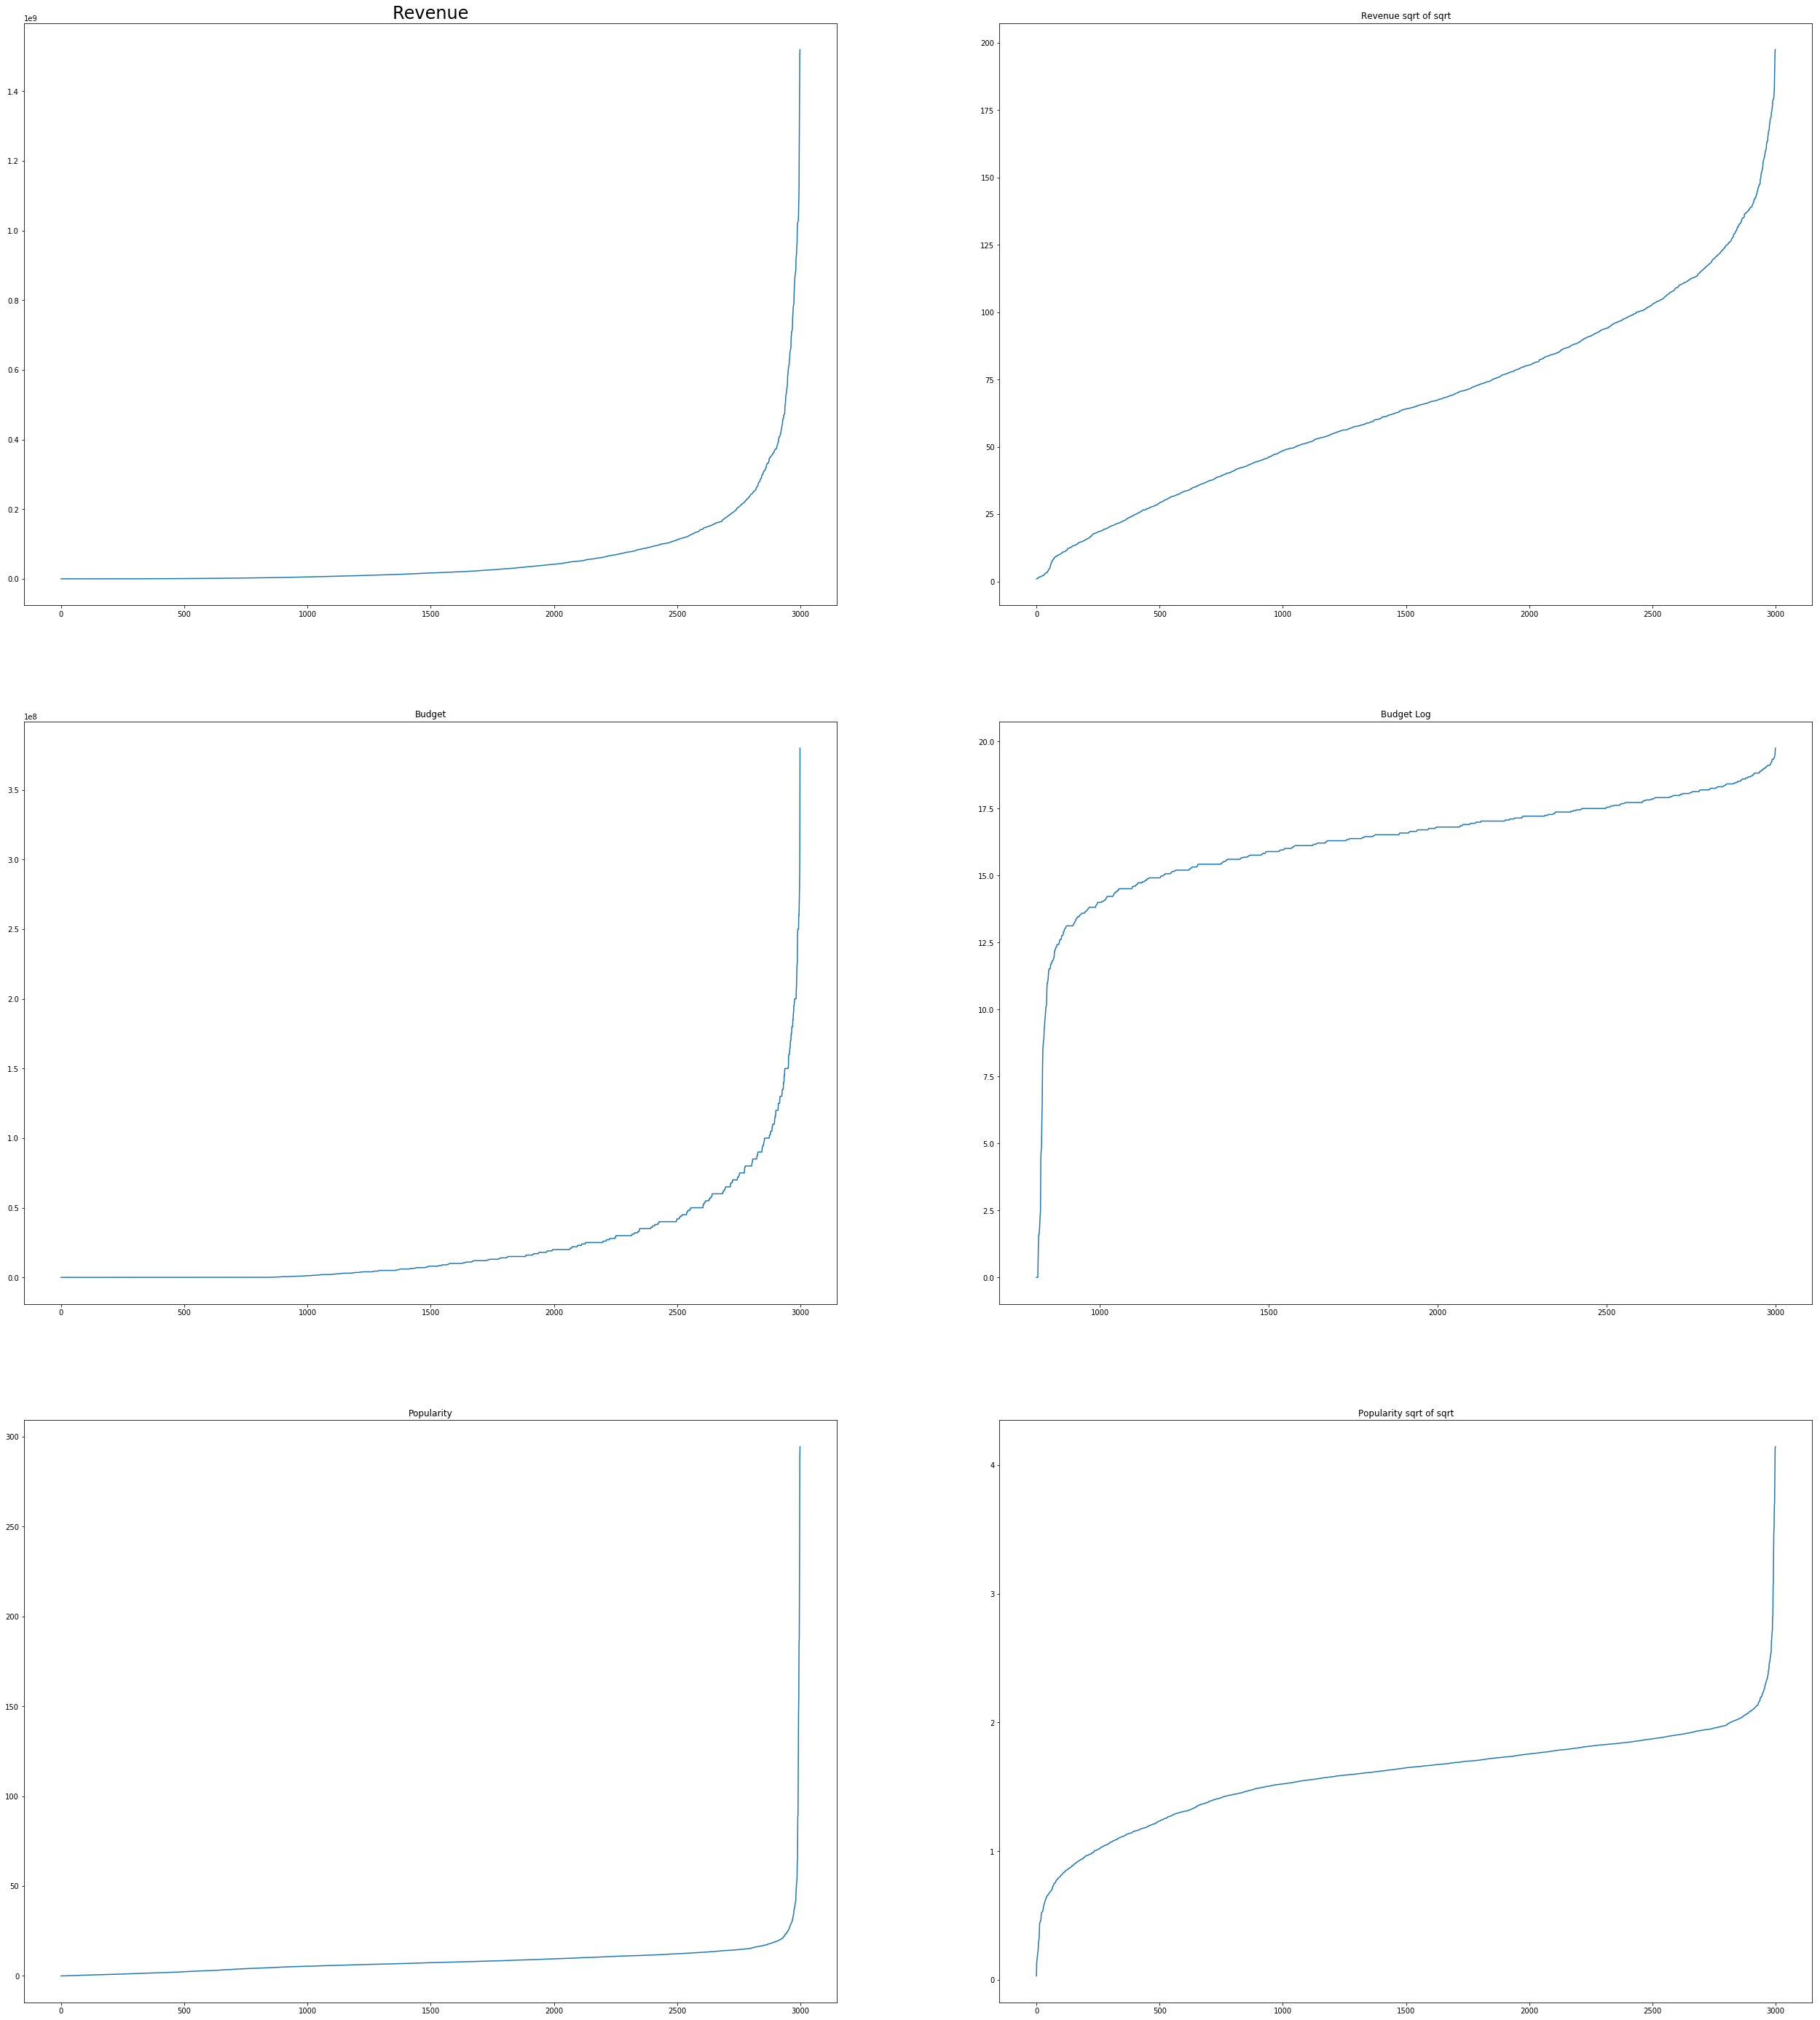

In [47]:
subplot, plots = plt.subplots(3, 2)
subplot.set_figheight(50)
subplot.set_figwidth(44)

plots[0][0].plot(training_data_set.revenue.sort_values().reset_index().revenue)
plots[0][0].set_title('Revenue', fontsize=24)

plots[0][1].plot(np.sqrt(np.sqrt(training_data_set.revenue.sort_values().reset_index().revenue)))
plots[0][1].set_title('Revenue sqrt of sqrt', fontsize=24)

plots[1][0].plot(training_data_set.budget.sort_values().reset_index().budget)
plots[1][0].set_title('Budget', fontsize=24)

plots[1][1].plot(np.log(training_data_set.budget.sort_values().reset_index().budget))
plots[1][1].set_title('Budget Log', fontsize=24)

plots[2][0].plot(training_data_set.popularity.sort_values().reset_index().popularity)
plots[2][0].set_title('Popularity', fontsize=24)

plots[2][1].plot(np.sqrt(np.sqrt(training_data_set.popularity.sort_values().reset_index().popularity)))
plots[2][1].set_title('Popularity sqrt of sqrt', fontsize=24)

plt.show()

## 1.4 More technical checks
1. Which columns have numerical data
2. Which columns contain missing values

In [10]:
print("Numerical columns: {}\n".format(training_data_set.select_dtypes(include=[np.number]).columns.tolist()))
print("Which columns have missing data: \n{}".format(training_data_set.isna().any()))

Numerical columns: ['id', 'budget', 'popularity', 'runtime', 'revenue']

Which columns have missing data: 
id                       False
belongs_to_collection     True
budget                   False
genres                    True
homepage                  True
imdb_id                  False
original_language        False
original_title           False
overview                  True
popularity               False
poster_path               True
production_companies      True
production_countries      True
release_date             False
runtime                   True
spoken_languages          True
status                   False
tagline                   True
title                    False
Keywords                  True
cast                      True
crew                      True
revenue                  False
dtype: bool


## 1.5 Categorical data analysis 


In [11]:
training_data_set['original_language'].unique()

array(['en', 'hi', 'ko', 'sr', 'fr', 'it', 'nl', 'zh', 'es', 'cs', 'ta',
       'cn', 'ru', 'tr', 'ja', 'fa', 'sv', 'de', 'te', 'pt', 'mr', 'da',
       'fi', 'el', 'ur', 'he', 'no', 'ar', 'nb', 'ro', 'vi', 'pl', 'hu',
       'ml', 'bn', 'id'], dtype=object)

Trainig set rows without date: 0
Testing set rows without date: 1


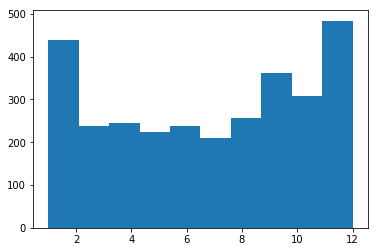

In [12]:
def get_release_month(data):
    release_months = [
        # Through out the whole data set (train + test) there's only one record
        # without release_date, so hardcoding the most common value doesn't seem
        # that outrageous 
        int(date.split('/')[0]) if date is not None else 12 
        for date in data['release_date']
    ]
    return release_months

def append_release_month_col(data, release_month):
    modified_data = data.copy()
    modified_data['release_month'] = release_month
    return modified_data

print("Trainig set rows without date: {}".format(training_data_set['release_date'].isna().any().sum()))
print("Testing set rows without date: {}".format(testing_data_set['release_date'].isna().any().sum()))

release_months = get_release_month(training_data_set)

plt.hist(release_months)
plt.show()



In [13]:
def get_dircetor(data):
    import ast
    director_list = []
    
    if data.columns.contains('crew'):
        crew_data = data['crew'].copy()
    else:
        crew_data = data.copy()
        
    for crew_info in crew_data:
        if type(crew_info) == type(''):
            directors = [
                [employee['id'], employee['name']]
                 for employee in ast.literal_eval(crew_info) 
                 if employee['job'] == 'Director']
            
            if not directors:
                director_list.append([[-1, 'None']])
            else:
                director_list.append(directors)
                
        else:
            director_list.append([[-1, 'None']])
        
    return director_list 

def append_director_col(data, director_list):
    modified_data = data.copy()
    modified_data['director'] = director_list
    return modified_data


unique_directors_train = pd.Series((director[0][0] for director in get_dircetor(training_data_set))).unique().size
unique_directors_test = pd.Series((director[0][0] for director in get_dircetor(testing_data_set))).unique().size

print("Movies in training set: {}, unique directors: {}. One director on average directs {:.2f} movies."
      .format(len(training_data_set), unique_directors_train, len(training_data_set) / unique_directors_train))
print("Movies in testing set: {}, unique directors: {}. One director on average directs {:.2f} movies."
      .format(len(testing_data_set), unique_directors_test, len(testing_data_set) / unique_directors_test))

Movies in training set: 3000, unique directors: 1858. One director on average directs 1.61 movies.
Movies in testing set: 4398, unique directors: 2451. One director on average directs 1.79 movies.


# 2. Data preparation
TODO:
1. Implement pipeline system
      Feature selection -> Imputing -> Normalization(scaling)
2. Add feature scaling (possibly with logarithmic scaling)
3. Add additional features

## 2.1 Defining methods



In [14]:
from sklearn.model_selection import train_test_split

def separate_only_numeric(data):
    """ Returns DataFrame with only numeric columns
    
    Arguments:
    data - DataFrame that will be used as source
    """
    return data.select_dtypes(include=[np.number])

def exclude_na_rows(data):
    """ Returns DataFrame where rows with na values have been removed
    
    Arguments:
    data - DataFrame that will be used as source
    """
    return data.dropna(axis='index')

def extract_label(data, columns=None, separate_label=True, label_name='revenue'):
    """ Separates the label from the data if specified, and selects only specified columns
    
    Arguments:
    data - array of data to be processed
    columns - columns to be left after preprocessing
    separate_label - whether to separate the label from the data and return it as a second parameter
    label_name - the name of the label column
    
    Returns: data_X, data_y
    """
    data_copy = data.copy()
    if separate_label: 
        data_y = data_copy.pop(label_name)
    else:
        data_y = [0 for _ in range(len(data_copy))]
    
    if columns is None:
        columns = data_copy.columns.difference(['id']).tolist()
    data_X = data_copy[columns]
    return data_X, data_y

def transform_dataset(data, test_size=0.3, only_numeric=True, delete_nan=True, separate_label=True):
    """ Preprocesses the data
    
    Arguments:
    data - array of data to be processed
    train_size - percentage (0 to 1) of data to be used as training data
    only_numeric - whether to use only numeric data
    training_data - whether this data has labels
    
    Returns: train_X, test_X, train_y, test_y
    """
    if only_numeric: 
        data = separate_only_numeric(data)
    if delete_nan:
        data = exclude_na_rows(data)
    data_X, data_y  = extract_label(data, separate_label=separate_label)
    return train_test_split(data_X, data_y, test_size=test_size, random_state=1)

## 2.2 Defining pipeline classes



In [16]:
from sklearn.base import TransformerMixin, BaseEstimator

class NumericDataSelector(TransformerMixin, BaseEstimator):
        
    def fit(self, data, labels=None):
        return self
        
    def transform(self, data, labels=None):
        return separate_only_numeric(data)
    
class FeatureSelector(TransformerMixin, BaseEstimator):
    
    def __init__(self, feature_names=None, remove_feature_names=None):
        self._feature_names = feature_names 
        self._remove_feature_names = remove_feature_names 
        
    def fit(self, data, labels=None):
        return self
        
    def transform(self, data, labels=None):
        if self._feature_names is None:
            self._feature_names = data.columns.tolist()
        
        if self._remove_feature_names is not None:
            self._feature_names = [feat for feat in self._feature_names if feat not in self._remove_feature_names]
        
        return data[self._feature_names]
    
class RootScaler(TransformerMixin, BaseEstimator):
    
    def __init__(self, scale_features=None, root_pow=4):
        self._scale_features = scale_features
        self._root_pow = root_pow
        
    def fit(self, data, labels=None):
        return self
    
    def transform(self, data, labels=None):
        if self._scale_features is None:
            self._scale_features = data.columns.tolist()
        
        scaled_data = data[self._scale_features]
        scaled_labels = labels
        
        for _ in range(0, self._root_pow, 2):
            scaled_data = np.sqrt(scaled_data)
            if scaled_labels is not None:
                scaled_labels = np.sqrt(scaled_labels)
        
        transformed_data = data.copy()
        transformed_data[self._scale_features] = scaled_data
        
        return transformed_data if scaled_labels is None else (transformed_data, scaled_labels)
   
class SimpleImputerWrapper(TransformerMixin):

    def __init__(self):
        from sklearn.impute import SimpleImputer
        self._imputer = SimpleImputer(missing_values=np.nan, strategy='median')
    
    def fit(self, data, labels=None):
        self._imputer.fit(data)
        return self
    
    def transform(self, data, labels=None):
        import pandas as pd
        imputed_data = self._imputer.transform(data)
        return pd.DataFrame(imputed_data, columns= data.columns)
        
class PrintData(TransformerMixin, BaseEstimator):
    
    def fit(self, data, labels=None):
        return self
    
    def transform(self, data, labels=None):
        print('Data length: {}, column count: {}'.format(len(data), len(data.columns)))
        print('Data:')
        print(data)
        
        if labels is not None:
            print("Labels:")
            print(labels)
            
        return data if labels is None else (data, labels)
        
class DateFeatureAdder(TransformerMixin, BaseEstimator):
    
    def fit(self, data, labels=None):
        return self
    
    def transform(self, data, labels=None):
        from sklearn.preprocessing import LabelBinarizer
        
        data_copy = data.copy()
        date_feature = get_release_month(data_copy)
        binarizer = LabelBinarizer()
        date_feature_binary = pd.DataFrame(binarizer.fit_transform(date_feature), columns=binarizer.classes_)
        
        data_copy = data_copy.reset_index()
        joint_columns = data_copy.columns.append(date_feature_binary.columns)
        data_copy = pd.concat([data_copy, date_feature_binary], axis=1, ignore_index=True)
        data_copy.columns = joint_columns
        data_copy.set_index('index')
        return data_copy

## 2.3 Creating training and testing data sets



In [17]:
data, labels = extract_label(training_data_set)
data_train, data_test, labels_train, labels_test = train_test_split(data, labels, test_size=0.3, random_state=1)

print("Training data set samples: {}, testing: {}".format(len(data_train), len(data_test)))
print("Full data set samples: {}.".format(len(data)))

Training data set samples: 2100, testing: 900
Full data set samples: 3000.


# 3. Model building
## 3.1. Setting up evaluation methods



In [18]:
from sklearn import metrics
from sklearn.model_selection import cross_val_score

def model_name(model):
    """ From a given model type extracts its name.
    
    Arguments:
    model -- the model object whose name is needed
    """
    model_name = str(type(model)).split('.')[-1][:-2]
    if model_name == 'Pipeline':
        model_name = model.steps[-1][0]
    return model_name

def model_rmsle(model, data, labels):
    """ Evaluates regression model accuracy using RMSLE error function.
    
    Arguments:
    model -- model to evaluate
    X -- data set to evaluate on
    y -- labels for evaluation
    """
    return np.sqrt(metrics.mean_squared_log_error(labels, np.abs(model.predict(data))))

def model_cv(model, data, labels, scoring='r2'):
    """ Calculates models cross-validationn performance with a given scoring method
    
    Arguments:
    model - model, which performance will be checked
    X - features
    y - labels
    scoring - scoring method (default r2)
    """
    return np.average(cross_val_score(model, data, labels, cv=5, scoring=scoring))

def evaluate_models(models_list, data, labels, cross_val=False):
    """ Evaluates model performance for all models in the list on a given data set (either a test set, or by cross val). 
    Returns a dictionary in such format {model_name: accuracy_score}
    
    Arguments:
    models_list -- list of sklearn models to evaluate
    data_X -- the data for making predictions
    data_y -- labels
    cross_val -- indicator whether to use cross validation
    """
    evaluations = {}
    for i, model in enumerate(models_list):
        evaluations.update({model_name(model) + str(i) : model_cv(model, data, labels) if cross_val else model_rmsle(model, data, labels)})
    
    return evaluations



## 3.2 Creating the pipelines



In [19]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import FunctionTransformer

extract_numeric_rows = ('Extract numeric rows', NumericDataSelector())
remove_id = ('Remove id column', FeatureSelector(remove_feature_names=['id']))
impute = ('Impute data', SimpleImputerWrapper())
scale_by_pow_4 = ('Scale data by root of power 4', RootScaler(scale_features=['budget']))
normalize = ('Normalize data', Normalizer())
print_data = ('Print data', PrintData())
month_feature_adder = ('Add binary release month', DateFeatureAdder())

numeric_only_steps = [
    ('Extract numeric rows', NumericDataSelector()),
    ('Remove id column', FeatureSelector(remove_feature_names=['id'])),
    ('Impute data', SimpleImputer(missing_values=np.nan, strategy='median'))
]

numeric_scaled_normalized_steps = [
    ('Extract numeric rows', NumericDataSelector()),
    ('Remove id column', FeatureSelector(remove_feature_names=['id'])),
    ('Impute data', SimpleImputerWrapper()),
    ('Scale data by root of power 4', RootScaler(scale_features=['budget'])),
    ('Normalize data', Normalizer(norm='max'))
]

numeric_and_month = [
    month_feature_adder,
    extract_numeric_rows,
    remove_id,
    impute,
    scale_by_pow_4,
    normalize
]

## 3.3 Creating & fitting the models
#1 The dummy regressor to be used as a sanity check for other model performance



In [32]:
from sklearn.dummy import DummyRegressor

dummy_regressor = DummyRegressor(strategy='median')
dummy_steps = numeric_only_steps.copy()
dummy_steps.append(('DummyRegressor', dummy_regressor))

dummy_pipeline = Pipeline(steps=dummy_steps)
dummy_pipeline.fit(data_train.copy(), labels_train.copy())
models = [dummy_pipeline]



#2 RandomForrestRegressor with only numeric data will be used as a baseline for other model performance



In [33]:
from sklearn.ensemble import RandomForestRegressor

random_forest = RandomForestRegressor()
random_forest_steps = numeric_only_steps.copy()
random_forest_steps.append(('Random forest regressor', random_forest))

random_forest_pipe = Pipeline(steps=random_forest_steps)
random_forest_pipe.fit(data_train.copy(), labels_train.copy())
models.append(random_forest_pipe)
 


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [34]:
random_forest_scaled_steps = numeric_scaled_normalized_steps.copy()
random_forest_scaled_steps.append(('Random forest scaled & normalized', random_forest))

random_forest_scaled_pipe = Pipeline(steps=random_forest_scaled_steps)
random_forest_scaled_pipe.fit(data_train.copy(), labels_train.copy())
models.append(random_forest_scaled_pipe)



In [35]:
from skopt import BayesSearchCV

random_forest_hyper_search = BayesSearchCV(
    RandomForestRegressor(), 
    {'n_estimators': (10, 100),
     'min_samples_split': (2, 20)},
    n_iter=32)

random_forest_hyper_steps = numeric_scaled_normalized_steps.copy()
random_forest_hyper_steps .append(('Random forest hyper tuning', random_forest_hyper_search))

random_forest_hyper_pipe = Pipeline(steps=random_forest_hyper_steps)
# random_forest_hyper_pipe.fit(data_train.copy(), labels_train.copy())
# models.append(random_forest_hyper_pipe)



In [36]:
random_forest_month_steps = numeric_scaled_normalized_steps.copy()
random_forest_month_steps.append(('Random forest hyper with month', random_forest_hyper_search))

random_forest_month_pipe = Pipeline(steps=random_forest_month_steps)
# random_forest_month_pipe.fit(data_train.copy(), labels_train.copy())
# models.append(random_forest_month_pipe)



#3 Support vector regressor



In [37]:
from sklearn.svm import SVR

svr = SVR()

support_vector_reg_steps = numeric_only_steps.copy()
support_vector_reg_steps.append(('SupportVectorRegressor', svr))
                       
support_vector_reg_pipe = Pipeline(support_vector_reg_steps)
support_vector_reg_pipe.fit(data_train.copy(), labels_train.copy())
models.append(support_vector_reg_pipe)



/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [38]:
svr_normalized_steps = numeric_scaled_normalized_steps.copy()
svr_normalized_steps.append(('SVR normalized', svr))

svr_normalized_pipe = Pipeline(svr_normalized_steps)
svr_normalized_pipe.fit(data_train.copy(), labels_train.copy())
models.append(svr_normalized_pipe)



/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


In [49]:
from skopt import BayesSearchCV

svr_hyper_model = BayesSearchCV(
    SVR(),
    {
        'C': (1e-6, 1e+6, 'log-uniform'),  
        'gamma': (1e-6, 1e+1, 'log-uniform'),
        'degree': (1, 8),
        'kernel': ['linear', 'poly', 'rbf'],
    },
    n_iter=32
)

svr_hyper_steps = numeric_scaled_normalized_steps.copy()
svr_hyper_steps.append(('SVR hyper tuning', svr_hyper_model))

svr_hyper_pipe = Pipeline(svr_hyper_steps)
# svr_hyper_pipe.fit(data_train.copy(), labels_train.copy())
# models.append(svr_hyper_pipe)



In [40]:
svr_hyper_month_steps = numeric_and_month.copy()
svr_hyper_month_steps.append(('SVR hyper & month', svr_hyper_model))

svr_hyper_month_pipe = Pipeline(svr_hyper_month_steps)
# svr_hyper_month_pipe.fit(data_train.copy(), labels_train.copy())
# models.append(svr_hyper_month_pipe)


#5 XGBoost regressor



In [41]:
from xgboost import XGBRegressor

xgbregressor = XGBRegressor()

xgboost_steps = numeric_only_steps.copy()
xgboost_steps.append(('XGBRegressor', xgbregressor))

xgboost_pipe = Pipeline(xgboost_steps)
xgboost_pipe.fit(data_train, labels_train)
models.append(xgboost_pipe)



/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [42]:
xgboost_month_steps = numeric_and_month.copy()
xgboost_month_steps.append(('XGBRegressor', xgbregressor))

xgboost_month_pipe = Pipeline(xgboost_month_steps)
# xgboost_month_pipe.fit(data_train, labels_train)
# models.append(xgboost_month_pipe)



# 4. Evaluation



In [43]:
evaluations = evaluate_models(models, data_test, labels_test, cross_val=False)

for model, score in evaluations.items():
    print("{} : {}".format(model, score))
    
    

DummyRegressor0 : 3.072308528597147
Random forest regressor1 : 4.5709520523831175
Random forest scaled & normalized2 : 2.7856254442026955
SupportVectorRegressor3 : 3.0723076844732833
SVR normalized4 : 3.0723055267848745
XGBRegressor5 : 2.711302439328345


# 5. Final predictions
## 5.1 Training the final model with full training data set and exporting predictions
Code bellow automatically uses the model with the highest score from models list



In [48]:
final_model = models[np.argmin(list(evaluations.values()))]
print("Final chosen model is: {}".format(model_name(final_model)))
final_model.fit(data, labels)

predictions = final_model.predict(testing_data_set)
pd.DataFrame(predictions, index=testing_data_set.id, columns=['revenue']).to_csv('./submission.csv')



Final chosen model is: XGBRegressor


/opt/conda/lib/python3.6/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
/opt/conda/lib/python3.6/site-packages/xgboost/core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


# Fin
Score result history:
1. 3.74493 (487th) - RandomForrestRegressor with only numeric data
2. 3.19264 (468th) - RandomForrestRegressor with only numeric data and removed id column
3. 2.77804 (467th) - XGBoost with only numeric and scaled
